# Assessing ML Model Performance in Parkinson's Disease Case and Controls

## Introduction

This notebook will assess several different contemporary ML model to assess classification on predicting cases and controls between PD user and non-PD users. I will use 80% training set and 20% test set. The training set will then be addressed for finding the best hyperparameters that gives the best performance for deployment. 

## Library Imports

In [1]:
# library and module imports for data retrieval and munging
import sys
import warnings
sys.path.append("../src/pipeline")
from utils import query_utils as query
from utils import gait_features_utils as gproc
import synapseclient as sc
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# extra commands
sns.set_style("darkgrid")
sns.set_context("paper")
warnings.simplefilter("ignore")

# some ML (scikit & xgboost) library imports for modelling
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import (train_test_split, learning_curve, GridSearchCV, cross_val_score, validation_curve)
import sklearn.metrics as metrics
from sklearn.metrics import (classification_report, confusion_matrix, roc_curve, auc, roc_auc_score)
from sklearn.preprocessing import (StandardScaler, MinMaxScaler)
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib
from sklearn.linear_model import (LogisticRegression, SGDClassifier)
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier)
from sklearn.feature_selection import RFECV, SelectKBest, chi2, SelectFromModel, RFE
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from xgboost import XGBClassifier

# magic commands
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Retrieve Data

#### Global Variables

In [2]:
WALKING_GROUPED_FEATURES = "syn21678699"
MATCHED_DEMOGRAPHICS = "syn21614563"
syn = sc.login()

Welcome, aryton tediarjo!



INFO:synapseclient_default:Welcome, aryton tediarjo!



### Helper Functions

#### a. Model Fitting Function

In [137]:
# helper functions

def reduce_feature_rfecv(X, y, 
                 estimator, 
                 score_func):
    """
    function to reduce features by
    recursively eliminating and adding
    features and optimize based on the
    scoring metrics provided
    
    Args: X: independent variables 
          y: dependent variables
          score_func: metrics to optimze
    returns reduced dataframe
    """
    selector = RFECV(estimator, step=1, 
                     cv=10, 
                     scoring = score_func, 
                     n_jobs = -1)
    selector = selector.fit(X, y)
    return pd.DataFrame(data = sel.transform(X), 
             columns = X.columns[sel.support_])



# below is helper function for wrapping the feature reduction and
# ML pipeline based on the model
def logreg_wrapper(X, y):
    model = LogisticRegression(random_state = 100)
    X = reduce_feature_rfecv(X, y, 
                             model, 
                             "roc_auc")
    features = X.columns
    pipe = Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('classifier', model)
        ])
    param = [{'classifier__penalty': ['l1'],
             'classifier__C':[0.5, 0.7, 1],
             'classifier__solver':['liblinear'],
             'classifier__max_iter': [100, 300, 500],
             'classifier__multi_class': ['ovr']}]
    CV = GridSearchCV(estimator = pipe, param_grid = param , 
                      scoring= "roc_auc", n_jobs = -1, 
                      cv = 10, verbose = True, refit = True)
    CV.fit(X, y)
    return {"model":CV, 
            "features":features}

def xgb_wrapper(X, y):
    model = XGBClassifier(seed = 100)
    X = reduce_feature_rfecv(X,y, 
                             model, 
                             "roc_auc")
    features = X.columns
    pipe = Pipeline(steps=[
        ('classifier', model)
        ])
    param = {
        "classifier__learning_rate" : [0.01, 0.05, 0.1],
        "classifier__n_estimators"  : [5, 10, 20, 50],
        'classifier__max_depth':[3, 5, 7],
        "classifier__gamma": [0.1, 0.2],
        "classifier__subsample": [0.7, 0.9, 1]
    }
    CV = GridSearchCV(estimator = pipe, param_grid = param, 
                      scoring= "roc_auc", n_jobs = -1, 
                      cv = 10, verbose = True, refit = True)
    CV.fit(X, y)
    return {"model":CV, 
            "features":features}
    

def gradientboost_wrapper(X, y):
    model = GradientBoostingClassifier(random_state = 100)
    X = reduce_feature_rfecv(X,y, 
                             model, 
                             "roc_auc")
    features = X.columns
    pipe = Pipeline(steps=[
        ('classifier', model)
        ])
    param = {
        'classifier__max_depth':[3, 5, 7, 9],
        'classifier__learning_rate': [0.01, 0.05, 0.1],
        "classifier__n_estimators"  : [5, 10, 20, 50],
        "classifier__subsample": [0.8, 0.9, 1]
    }
    CV = GridSearchCV(estimator = pipe, param_grid = param , 
                      scoring= "roc_auc", n_jobs = -1, 
                      cv = 10, verbose = True, refit = True)
    CV.fit(X, y)
    return {"model":CV, 
            "features":features}


def randomforest_wrapper(X, y):
    model = RandomForestClassifier(random_state = 100)
    X = reduce_feature_rfecv(X,y, 
                             model, 
                             "roc_auc")
    features = X.columns
    pipe = Pipeline(steps=[
        ('classifier', model)
        ])
    param = {
        'classifier__n_estimators'  : [5, 10, 20, 50],
        'classifier__min_samples_split':[2, 5, 10],
        'classifier__min_samples_leaf' : [1, 2, 4],
        'classifier__max_depth': [3, 4, 5]
    }
    CV = GridSearchCV(estimator = pipe, param_grid = param, 
                      scoring= "roc_auc", n_jobs = -1, cv = 10, 
                      verbose = True, refit = True)
    CV.fit(X, y)
    return {"model":CV, 
            "features":features}

#### b. Model Results & Visualization Function

In [166]:
def get_results_dataframe(X_train, y_train, 
                          X_test, y_test, 
                          *fitted_models):
    data_dict = {}
    data_dict["model"] = []
    data_dict["parameter"] = []
    data_dict["roc-auc-cv"] = []
    data_dict["roc-auc-test"] = []
    data_dict["log-loss-test"] = []
    data_dict["f1-score-test"] = []
    for fitted_model in fitted_models:
        if isinstance(fitted_model, dict):
            model = fitted_model["model"]
            features = fitted_model["features"]
        else:
            model    = fitted_model
            features = X_test.columns 
        try:
            data_dict["model"].append(type(model.best_estimator_["classifier"]).__name__)
            data_dict["parameter"].append(model.best_params_)
            data_dict["roc-auc-cv"].append(model.best_score_)
        except:
            data_dict["model"].append(type(model).__name__)
            data_dict["parameter"].append(np.NaN)
            data_dict["roc-auc-cv"].append(np.mean(cross_val_score(model, X_train, 
                                                           y_train, scoring = "roc_auc")))
        y_true, y_pred = y_test, model.predict(X_test[features])
        data_dict["roc-auc-test"].append(metrics.roc_auc_score(y_true, y_pred))
        data_dict["log-loss-test"].append(metrics.log_loss(y_true, y_pred))
        data_dict["f1-score-test"].append(metrics.f1_score(y_true, y_pred))
    data = pd.DataFrame(data_dict)
    return data


def visualize_feature_importances(X, *fitted_models):
    for fitted_model in fitted_models:
        try:
            features = fitted_model.best_estimator_["classifier"].feature_importances_
        except:
            features = fitted_model.best_estimator_["classifier"].coef_[0]

        series = np.abs(pd.Series(data = features, 
                            index = X.columns))\
                            .sort_values(ascending = True).tail(20)
        plt.figure(figsize = (8,5))
        plt.title("Feature Importances based base on %s"%type(fitted_model.best_estimator_["classifier"]).__name__)
        series.plot(kind = "barh")
        plt.show()
        

def plot_roc_auc_curve(X_test, y_test, *fitted_models):
    for fitted_model in fitted_models:
        model_name = type(fitted_model.best_estimator_["classifier"]).__name__
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        y_pred = fitted_model.predict_proba(X_test)
        for i in range(2):
            fpr[i], tpr[i], _ = roc_curve(y_test, y_pred[:,i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[1], tpr[1], linestyle='-', 
                 label='%s ROC curve (area = %0.2f)' % 
                 (model_name, roc_auc[1]))
    
    

def plot_learning_curves(X_train, y_train, *fitted_models):
    for fitted_model in fitted_models:
        try:
            estimator = fitted_model.best_estimator_
            model_name = type(fitted_model.best_estimator_["classifier"]).__name__
        except:
            estimator = fitted_model
            model_name = type(fitted_model).__name__
        train_sizes, train_scores, valid_scores = learning_curve(estimator, 
                                                                X_train, y_train, 
                                                                scoring = "roc_auc", 
                                                                cv = 5, random_state = 100, 
                                                                train_sizes = np.linspace(0.1, 1, 10))
        pd.DataFrame(data = {"train_scores": np.mean(train_scores, axis = 1), 
                             "valid_scores": np.mean(valid_scores, axis = 1)}, 
                     index = train_sizes)\
                    .plot(figsize = (8,5), linestyle='-', marker = 'o')
        plt.ylabel("roc-auc")
        plt.title("%s Learning Curve"%model_name)
        plt.xlabel("Training Size")
        plt.show()
        
def plot_rfecv_performance(X_train, y_train, *fitted_models):
    plt.figure(figsize = (12,8))
    for fitted_model in fitted_models:
        selector = RFECV(fitted_model, 
                         step=1, 
                         cv=10, 
                         scoring = "roc_auc", 
                         n_jobs = -1)
        selector = selector.fit(X_train_impute, y_train)
        # Plot number of features VS. cross-validation scores
        plt.xlabel("Number of features selected")
        plt.ylabel("Cross validation AUC-ROC score")
        plt.plot(range(1, len(selector.grid_scores_) + 1), 
                 selector.grid_scores_, 
                 label = type(fitted_model).__name__)
    plt.title("AUC-ROC Score Based on RFECV (10-fold)")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

#### Preliminary Cleanups

In [139]:
# get data
data = query.get_file_entity(syn, WALKING_GROUPED_FEATURES )
demographic = query.get_file_entity(syn, MATCHED_DEMOGRAPHICS)

# filter unused columns
data = data[[feat for feat in data.columns 
             if ("window" not in feat) 
             and ("steps" not in feat) 
             and ("consec_zero_cadence" not in feat)]]

# filter datasets
data = data[(data["test_type"] == "walking") & 
            (data["age"] > 0) & 
            (data["table_version"] != "MPOWER_PASSIVE") &
            (data["class"] != "MS")]

# merge inner
data = pd.merge(
    demographic[["healthCode"]], data, on = "healthCode", how = "inner")

data = data.set_index("healthCode")

# clean sparse feature
data = data[data.columns[data.isnull().mean() < 0.2]]

# cols of choice
metadata_cols = ["test_type", "phoneInfo", "age", 
                 "gender", "table_version", 
                 "nrecords", "class"]
feat_cols = [feat for feat in data.columns if (feat not in metadata_cols)]

### 1. Impute missing data on training using MICE Model (Iterative Imputer)

In this data model, I will be imputing missing values using the MICE imputer. Essentially, by using MICE imputer, we will be using regression (repeatedly) to fit null values by using other known data. MICE iterative imputer is chosen due to the assumption that the missing values might be a MAR (missing at random) where the users might or might not showcased a certain gait signal because of random occurence e.g. null in rotation speed is just a random occurence that the user are not doing any rotation; MICE imputer is also a good generalization model that does not assume disassociation between one column to another, meaning that it will not cause as much bias as towards simply imputing by mean or median.

<b> This imputer is still a generalized model and might be subject to future improvement. </b>

In [140]:
train = data[feat_cols]
target = data["class"].map({"PD":1, "control":0})

# split train test split
X_train, X_test, y_train, y_test = train_test_split(
    train, target,                                          
    test_size = 0.2,                                
    random_state = 100)

imputer = IterativeImputer(
    random_state=100, 
    initial_strategy = "median")\
    .fit(X_train)

X_train_impute = pd.DataFrame(imputer.fit_transform(X_train), 
                              columns = X_train.columns)
X_test_impute = pd.DataFrame(imputer.fit_transform(X_test), 
                             columns = X_train.columns)

### 2. Assessing Initial Model Performance

Before we do any optimization on any of the ML model, we would like to have a baseline model based on the features that we currently have. Thus, we will test the baseline model by simply fit/predict on the training and test sets of our feature data, see what the initial performances <b> (roc-auc, f1-score, log-loss) </b> look like, and try to iterate/improve the baseline model. We will also be assessing the learning curve of our initial model and see whether the initial model can pick up some signals from the feature data. 

#### a. Initial Model Fitting

In [147]:
init_lr_model = LogisticRegression(random_state = 100)\
                .fit(X_train_impute, y_train)

init_rf_model = RandomForestClassifier(
                random_state = 100, 
                n_estimators = 10)\
                .fit(X_train_impute, y_train)

init_gb_model = GradientBoostingClassifier(
                random_state = 100, 
                n_estimators = 10)\
                .fit(X_train_impute, y_train)

init_xgb_model = XGBClassifier(
                random_state = 100, 
                n_estimators = 10)\
                .fit(X_train_impute, y_train, verbose=True)

init_etree_model = ExtraTreesClassifier(
                    random_state = 100, 
                    n_estimators = 10)\
                    .fit(X_train_impute, y_train)

init_adaboost_model = AdaBoostClassifier(
                    random_state = 100, 
                    n_estimators = 5)\
                    .fit(X_train_impute, y_train)

init_sgd_model = SGDClassifier(random_state = 100)\
                .fit(X_train_impute, y_train)

init_svc_model = SVC(random_state = 100)\
                .fit(X = X_train_impute, y = y_train)

init_knn_model = KNeighborsClassifier()\
                .fit(X = X_train_impute, y = y_train)

init_gnb_model = GaussianNB()\
                .fit(X = X_train_impute, y = y_train)

init_LDA_model = LinearDiscriminantAnalysis()\
                .fit(X = X_train_impute, y = y_train)

init_QDA_model = QuadraticDiscriminantAnalysis()\
                .fit(X = X_train_impute, y = y_train)

#### b. Initial Model Metrics Performance

In [151]:
get_results_dataframe(X_train_impute, y_train,
                      X_test_impute, y_test, 
                    init_xgb_model,
                    init_lr_model,
                    init_gb_model,
                    init_rf_model, 
                    init_etree_model,
                    init_adaboost_model, 
                    init_sgd_model, 
                    init_svc_model, 
                    init_knn_model, 
                    init_gnb_model, 
                    init_LDA_model,
                    init_QDA_model)

,model,parameter,roc-auc-cv,roc-auc-test,log-loss-test,f1-score-test
0,XGBClassifier,NaN,0.628673,0.611840,13.257448,0.571429
1,LogisticRegression,NaN,0.624708,0.619497,13.257491,0.617450
2,GradientBoostingClassifier,NaN,0.623148,0.638160,12.443408,0.613718
3,RandomForestClassifier,NaN,0.587360,0.572942,14.536667,0.517375
4,ExtraTreesClassifier,NaN,0.593588,0.537667,15.699595,0.466403
5,AdaBoostClassifier,NaN,0.588026,0.579779,14.885644,0.612121
6,SGDClassifier,NaN,0.603441,0.448865,19.886347,0.562660
7,SVC,NaN,0.607710,0.611088,13.373756,0.584838
8,KNeighborsClassifier,NaN,0.559518,0.537804,16.048533,0.533784
9,GaussianNB,NaN,0.612846,0.598100,13.606308,0.533865


#### c. Learning Curve

We will try to fit visualize learning curves on the top 5 model (sklearn-GB, XGB, LogReg, RF) and see whether the model is able to learn from our dataset. 

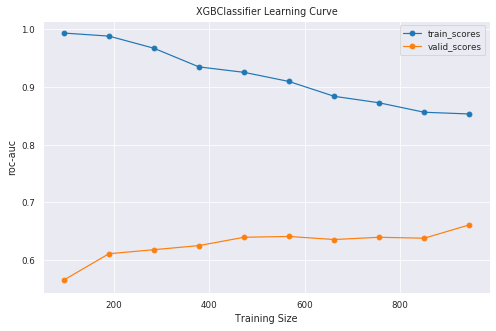

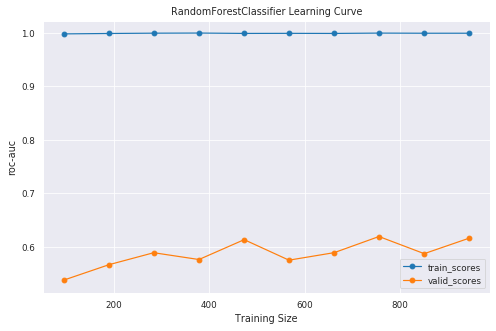

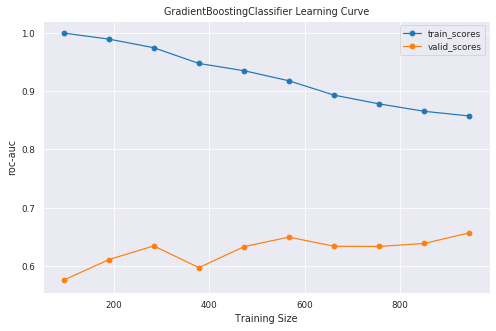

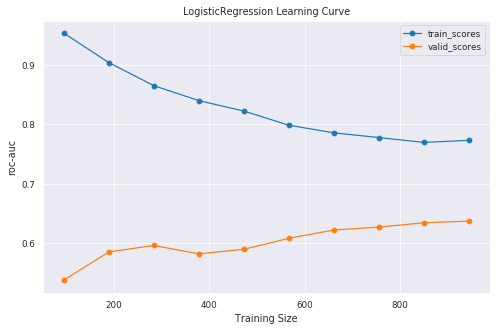

In [170]:
plot_learning_curves(X_train_impute, y_train, 
                     init_xgb_model,
                     init_rf_model,
                     init_gb_model,
                     init_lr_model)

##### Learning Curve Diagnostics on Initial Model

Looking from the learning curve above, we can see that there is still a huge gap between the training scores and the valid scores, this indicates high variance in our model, meaning that our model is still slightly overfitting, especially the Random Forest Model as its training scores is perfect throughout the increase of training data. An ideal model is where we can see the the training scores and valid scores converge closer to each other, which can happen through dimensionality reduction or having more data. As having more data is not viable right now, we will try to reduce the dimensionality/features in our ML model.

#### d. Visualizing Feature Elimination

An approach of feature elimination can be done recursively, by adding and eliminating feature combinations repeatedly. This process is more effective than manually eliminating the features but it will be a time-consuming process as the data scales up. However, as we have large number of features but not as much samples on the dataset, this feature will be advantageous as we will not require that much time in repeatedly fitting the model with different subset of features. 

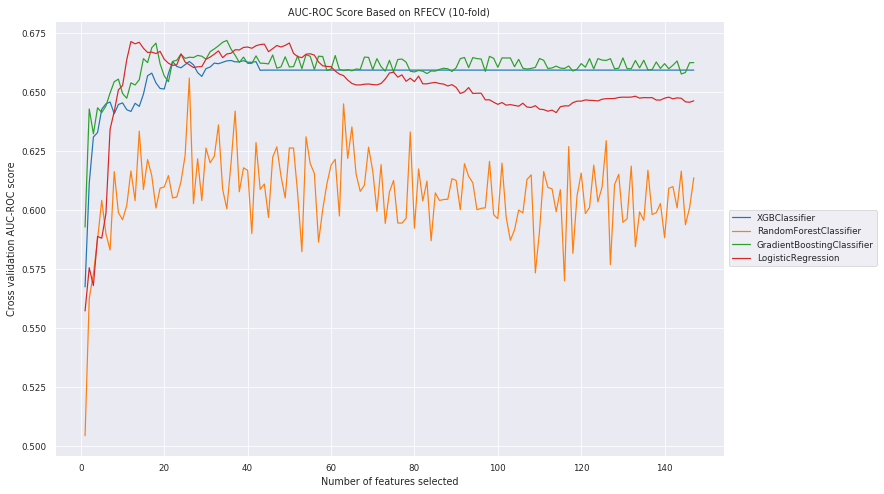

In [164]:
plot_rfecv_performance(X_train_impute, y_train, 
                        init_xgb_model,
                        init_rf_model,
                        init_gb_model,
                        init_lr_model)

Looking from the features usage above, we can see that we do not necessarily require 140 features to reach the optimal result of our model. Thus, it is possible that we will be able to improve the model that retains around as much AUC-ROC performance without overfitting the data with too much features. 

## 3. Optimizing ML Model Performance

Summarizing the analysis of our model initial above, here are the approach that we will take to improve our feature data's predictive performances:

    1. Impute Data using MICE Iterative Imputer 

    2. Recursive Feature Elimination to reduce overfitting 

    3. Grid Search the model hyperparameter with 10-fold cross validation 
       to optimize desired prediction metrics (roc-auc)

    4. Assess Model Performance (metrics, learning curve) 

    5. Assess Feature Importances 

    6. Persist Best Model 

#### a. Optimized Models using RFECV and Grid Search

In [154]:
 ## models ##
cv_lr_model = logreg_fit(X_train_impute, y_train)
cv_rf_model = randomforest_fit(X_train_impute, y_train)
cv_gb_model = gradientboost_fit(X_train_impute, y_train)
cv_xgb_model = xgb_fit(X_train_impute, y_train)

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    2.0s finished


Fitting 10 folds for each of 108 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed:   10.1s finished


Fitting 10 folds for each of 27 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:    5.2s finished


Fitting 10 folds for each of 162 candidates, totalling 1620 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 692 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 1392 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 1620 out of 1620 | elapsed:   12.8s finished


#### b. Prediction Results Dataframe

In [160]:
get_results_dataframe(X_train, y_train,
                      X_test_impute, 
                      y_test, 
                      cv_gb_model,
                      cv_rf_model,
                      cv_lr_model,
                      cv_xgb_model)

,model,parameter,roc-auc-cv,roc-auc-test,log-loss-test,f1-score-test
0,GradientBoostingClassifier,"{'classifier__learning_rate': 0.1, 'classifier...",0.697027,0.617378,13.141167,0.589091
1,RandomForestClassifier,"{'classifier__max_depth': 5, 'classifier__min_...",0.685236,0.630640,12.792304,0.618056
2,LogisticRegression,"{'classifier__C': 1, 'classifier__max_iter': 1...",0.671502,0.641236,12.559738,0.644737
3,XGBClassifier,"{'classifier__gamma': 0.2, 'classifier__learni...",0.692413,0.643218,12.327124,0.626761


The ML prediction shows that the optimized model have better cross validation score, scoring above 0.65 in general. 

#### c. Feature Importances

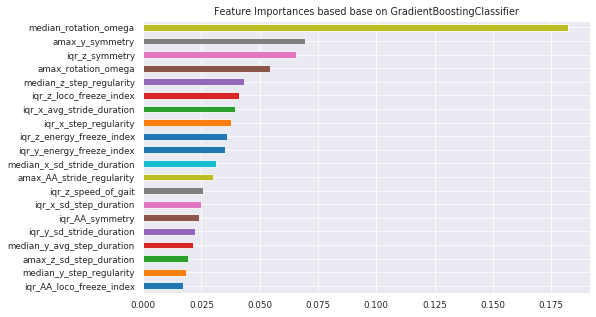

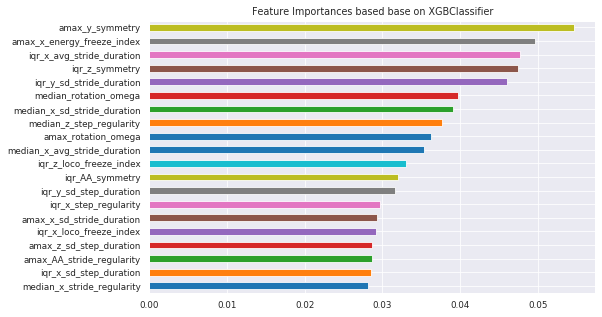

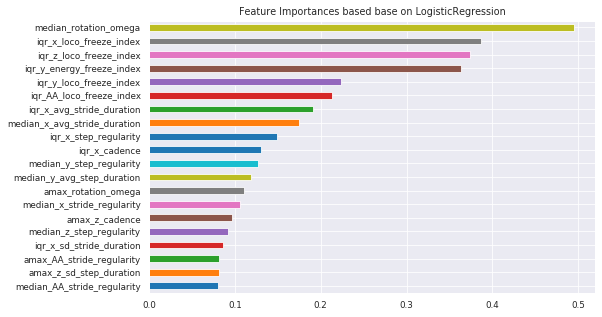

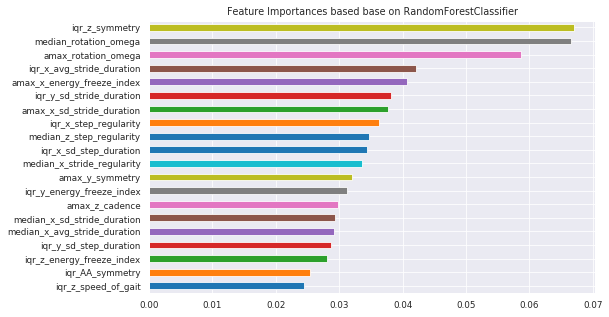

In [167]:
for fitted_model in [cv_gb_model, cv_xgb_model, cv_lr_model, cv_rf_model]:
    visualize_feature_importances(X_train_impute[fitted_model["features"]], 
                                  fitted_model["model"])

#### d. ROC-AUC Curve

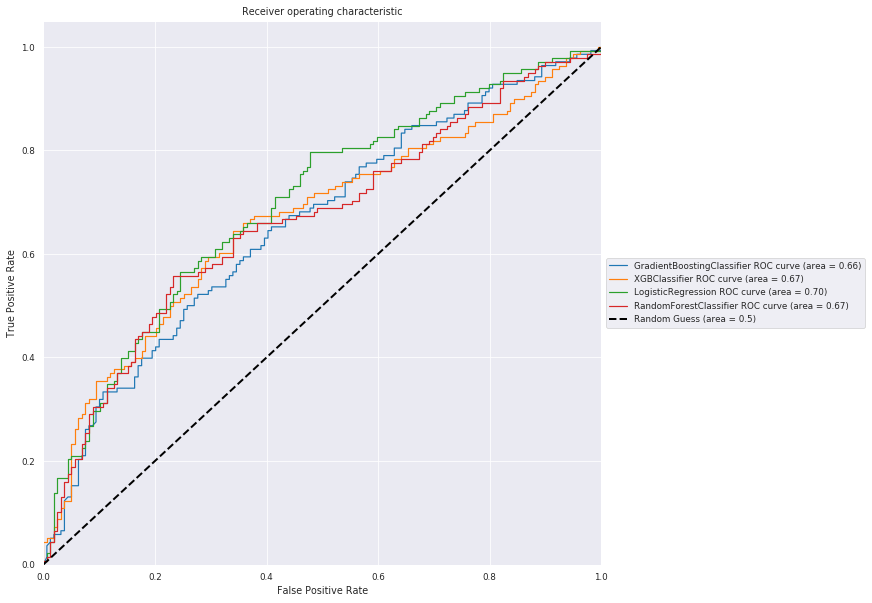

In [168]:
plt.figure(figsize = (10,10))


for fitted_model in [cv_gb_model, cv_xgb_model, cv_lr_model, cv_rf_model]:
    plot_roc_auc_curve(X_test_impute[fitted_model["features"]], 
                       y_test, 
                       fitted_model["model"])

plt.plot([0, 1], [0, 1], color='black', 
             lw=2, linestyle='--', 
             label = "Random Guess (area = 0.5)")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

#### e. Learning Curve (Train - 10 fold cross validation set)

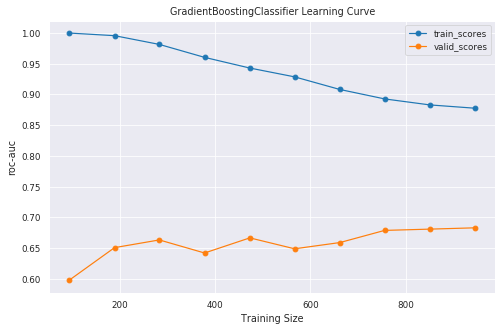

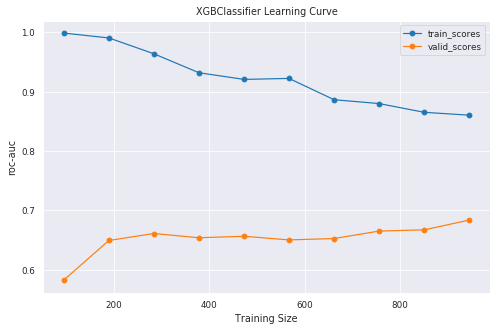

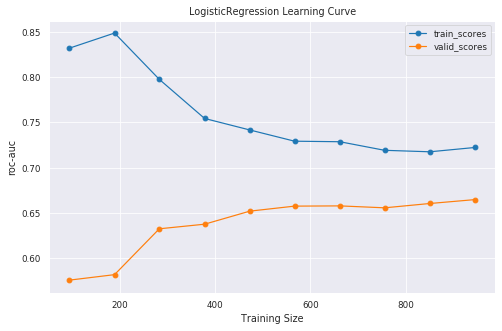

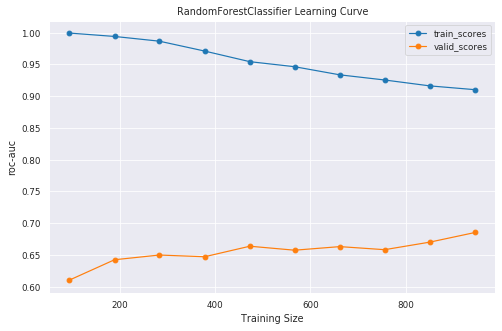

In [169]:
for fitted_model in [cv_gb_model, cv_xgb_model, cv_lr_model, cv_rf_model]:
    plot_learning_curves(X_train_impute[fitted_model["features"]], 
                         y_train, 
                         fitted_model["model"])

### Results:


The assessment above shows that the optimized model are able to score above >0.65 AUC-ROC, which means that our model is quite able to pick up some signals from our feature data. However, looking from the learning curves, despite our best effort in reducing variance between the training and cross-validation scores through feature reduction, it seems that it could only improve by a small margin. <b> Logistic Regression </b> (so-far) might be a reasonable model in deployment due to its capability to generalize the features due to its small difference between the training scores and cross validation scores, as seen from the learning curve. 